# Lab 2.3: Gradient Descent from Scratch

**Duration:** 45 minutes

## Learning Objectives
By the end of this lab, you will be able to:
- Understand the mathematical foundations of gradient descent optimization
- Implement gradient descent algorithms from scratch using NumPy
- Compare different variants: batch, stochastic, and mini-batch gradient descent
- Visualize the optimization process and understand convergence behavior
- Apply gradient descent to optimize real machine learning problems
- Analyze the effect of learning rates and other hyperparameters

## Prerequisites
- Python 3.8+
- NumPy, Matplotlib
- Understanding of derivatives and basic calculus
- Completed Lab 2.1 (Logistic Regression)

## Overview
Gradient descent is the backbone of machine learning optimization. This lab provides a deep dive into implementing gradient descent from scratch, understanding its variants, and visualizing how it finds optimal solutions. You'll build intuition for why gradient descent works and how to tune it effectively.

## Step 1: Environment Setup and Mathematical Background

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from sklearn.datasets import make_regression, make_classification
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

print("Environment setup complete!")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

# Mathematical foundation reminder
print("\nGradient Descent Mathematical Foundation:")
print("=========================================")
print("Goal: Minimize cost function J(θ)")
print("Update rule: θ = θ - α * ∇J(θ)")
print("Where:")
print("  θ = parameters (weights)")
print("  α = learning rate")
print("  ∇J(θ) = gradient of cost function")

Environment setup complete!
NumPy version: 2.3.2
Matplotlib version: 3.10.5

Gradient Descent Mathematical Foundation:
Goal: Minimize cost function J(θ)
Update rule: θ = θ - α * ∇J(θ)
Where:
  θ = parameters (weights)
  α = learning rate
  ∇J(θ) = gradient of cost function


## Step 2: Simple 1D Gradient Descent Visualization

Let's start with a simple 1D example to build intuition about how gradient descent works.

LR=0.01: Final x=0.5433, Final cost=3.1219, Iterations to converge: 50
LR=0.1: Final x=1.9999, Final cost=1.0000, Iterations to converge: 50
LR=0.3: Final x=2.0000, Final cost=1.0000, Iterations to converge: 50
LR=0.9: Final x=1.9999, Final cost=1.0000, Iterations to converge: 50


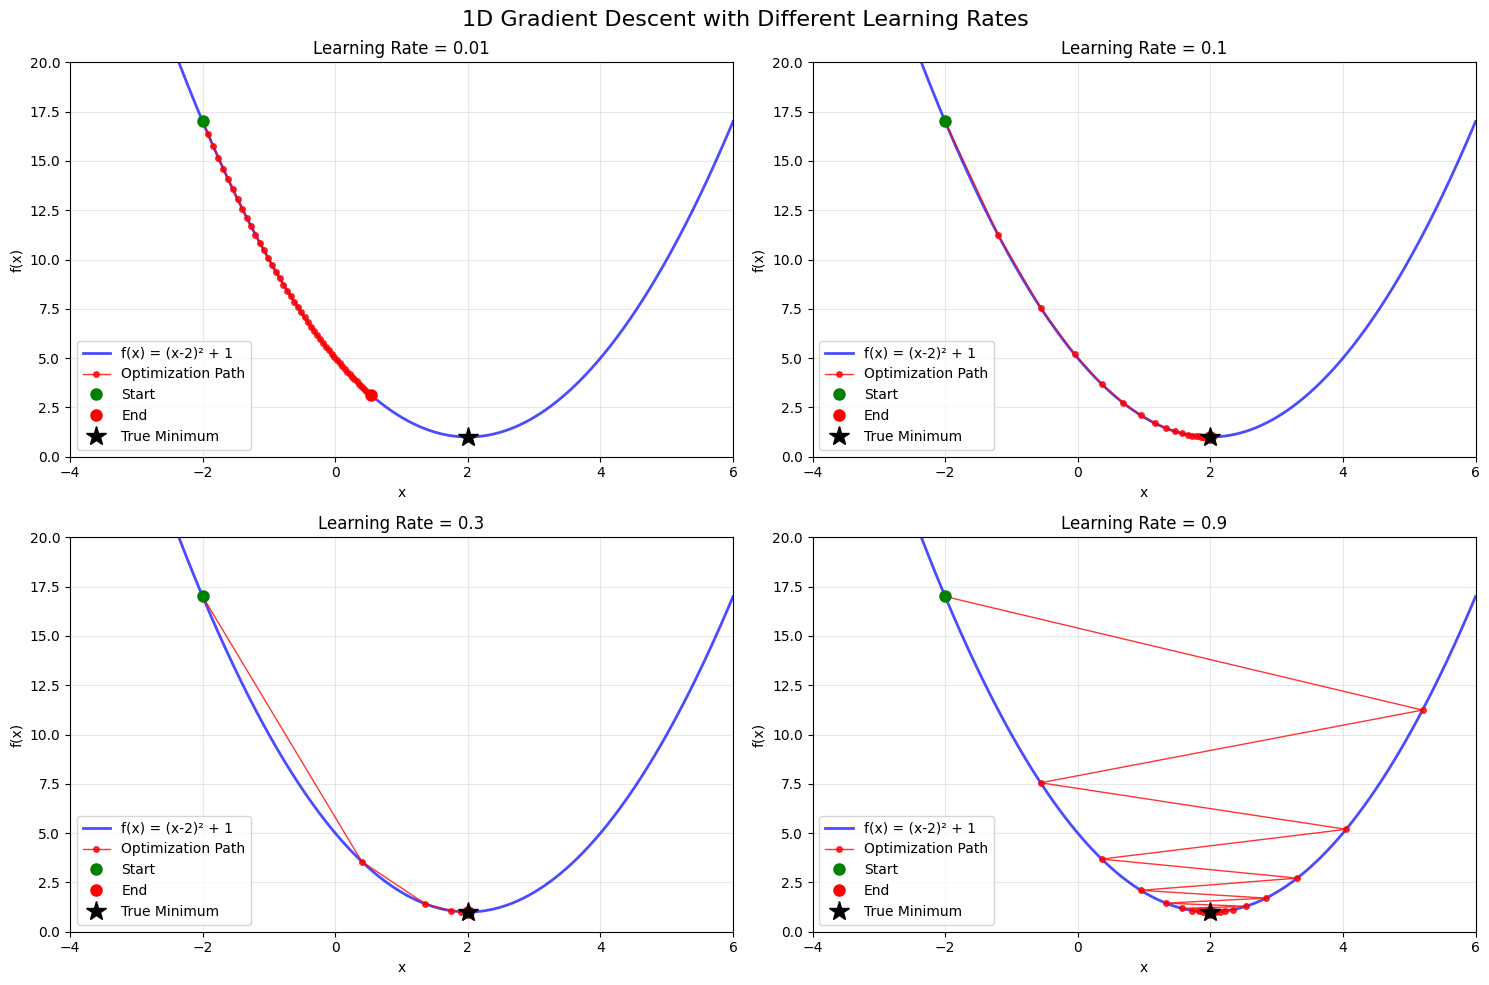


✓ 1D gradient descent visualization completed!


In [2]:
def simple_quadratic_function(x):
    """
    Simple quadratic function: f(x) = (x - 2)^2 + 1
    Minimum at x = 2, f(2) = 1
    """
    return (x - 2)**2 + 1

def simple_quadratic_derivative(x):
    """
    Derivative of the quadratic function: f'(x) = 2(x - 2)
    """
    return 2 * (x - 2)

def gradient_descent_1d(start_x, learning_rate, num_iterations, func, grad_func):
    """
    1D gradient descent implementation
    
    Arguments:
    start_x -- starting point
    learning_rate -- step size
    num_iterations -- number of iterations
    func -- function to minimize
    grad_func -- gradient function
    
    Returns:
    x_history -- history of x values
    cost_history -- history of function values
    """
    x = start_x
    x_history = [x]
    cost_history = [func(x)]
    
    for i in range(num_iterations):
        # Calculate gradient
        gradient = grad_func(x)
        
        # Update parameter
        x = x - learning_rate * gradient
        
        # Record history
        x_history.append(x)
        cost_history.append(func(x))
    
    return np.array(x_history), np.array(cost_history)

# Test with different learning rates
learning_rates = [0.01, 0.1, 0.3, 0.9]
start_point = -2.0
iterations = 50

plt.figure(figsize=(15, 10))

# Plot the function
x_range = np.linspace(-4, 6, 1000)
y_range = simple_quadratic_function(x_range)

for i, lr in enumerate(learning_rates):
    plt.subplot(2, 2, i + 1)
    
    # Plot function
    plt.plot(x_range, y_range, 'b-', linewidth=2, alpha=0.7, label='f(x) = (x-2)² + 1')
    
    # Run gradient descent
    x_hist, cost_hist = gradient_descent_1d(
        start_point, lr, iterations, 
        simple_quadratic_function, simple_quadratic_derivative
    )
    
    # Plot optimization path
    plt.plot(x_hist, cost_hist, 'ro-', markersize=4, linewidth=1, 
            alpha=0.8, label=f'Optimization Path')
    
    # Mark start and end points
    plt.plot(x_hist[0], cost_hist[0], 'go', markersize=8, label='Start')
    plt.plot(x_hist[-1], cost_hist[-1], 'ro', markersize=8, label='End')
    
    # Mark true minimum
    plt.plot(2, 1, 'k*', markersize=15, label='True Minimum')
    
    plt.title(f'Learning Rate = {lr}')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xlim(-4, 6)
    plt.ylim(0, 20)
    
    # Print final results
    final_x = x_hist[-1]
    final_cost = cost_hist[-1]
    print(f"LR={lr}: Final x={final_x:.4f}, Final cost={final_cost:.4f}, "
          f"Iterations to converge: {len(x_hist)-1}")

plt.suptitle('1D Gradient Descent with Different Learning Rates', fontsize=16)
plt.tight_layout()
plt.show()

print("\n✓ 1D gradient descent visualization completed!")

## Step 3: Gradient Descent for Linear Regression

Now let's implement gradient descent for a real machine learning problem: linear regression.

In [3]:
class LinearRegressionGD:
    """
    Linear Regression using Gradient Descent
    """
    
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        """
        Initialize the model
        
        Arguments:
        learning_rate -- step size for gradient descent
        max_iterations -- maximum number of iterations
        tolerance -- convergence tolerance
        """
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        
        self.weights = None
        self.bias = None
        self.cost_history = []
        self.weight_history = []
        self.converged_at = None
    
    def _add_bias(self, X):
        """
        Add bias column to feature matrix
        """
        return np.c_[np.ones((X.shape[0], 1)), X]
    
    def _compute_cost(self, X, y, weights):
        """
        Compute Mean Squared Error cost
        
        Arguments:
        X -- features with bias column
        y -- target values
        weights -- model parameters
        
        Returns:
        cost -- MSE cost
        """
        m = len(y)
        predictions = X.dot(weights)
        cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
        return cost
    
    def _compute_gradients(self, X, y, weights):
        """
        Compute gradients for linear regression
        
        Arguments:
        X -- features with bias column
        y -- target values
        weights -- current model parameters
        
        Returns:
        gradients -- gradients with respect to weights
        """
        m = len(y)
        predictions = X.dot(weights)
        errors = predictions - y
        gradients = (1 / m) * X.T.dot(errors)
        return gradients
    
    def fit(self, X, y):
        """
        Train the model using gradient descent
        
        Arguments:
        X -- training features (m, n)
        y -- training targets (m,)
        """
        # Ensure y is column vector
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        
        # Add bias column
        X_with_bias = self._add_bias(X)
        
        # Initialize weights randomly
        n_features = X_with_bias.shape[1]
        self.weights = np.random.normal(0, 0.01, (n_features, 1))
        
        # Initialize tracking
        self.cost_history = []
        self.weight_history = []
        
        # Gradient descent loop
        for i in range(self.max_iterations):
            # Compute cost
            cost = self._compute_cost(X_with_bias, y, self.weights)
            self.cost_history.append(cost)
            self.weight_history.append(self.weights.copy())
            
            # Compute gradients
            gradients = self._compute_gradients(X_with_bias, y, self.weights)
            
            # Update weights
            self.weights = self.weights - self.learning_rate * gradients
            
            # Check for convergence
            if len(self.cost_history) > 1:
                cost_change = abs(self.cost_history[-2] - self.cost_history[-1])
                if cost_change < self.tolerance:
                    self.converged_at = i
                    print(f"Converged at iteration {i}")
                    break
            
            # Print progress
            if i % 100 == 0:
                print(f"Iteration {i}: Cost = {cost:.6f}")
        
        # Separate bias and weights
        self.bias = self.weights[0, 0]
        self.weights = self.weights[1:]
    
    def predict(self, X):
        """
        Make predictions
        
        Arguments:
        X -- input features
        
        Returns:
        predictions -- predicted values
        """
        return X.dot(self.weights) + self.bias
    
    def score(self, X, y):
        """
        Calculate R² score
        """
        predictions = self.predict(X)
        ss_res = np.sum((y - predictions) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        return r2

print("✓ LinearRegressionGD class implemented successfully!")

✓ LinearRegressionGD class implemented successfully!


Regression dataset created:
Shape: (100, 1)
Target range: [-118.03, 89.03]


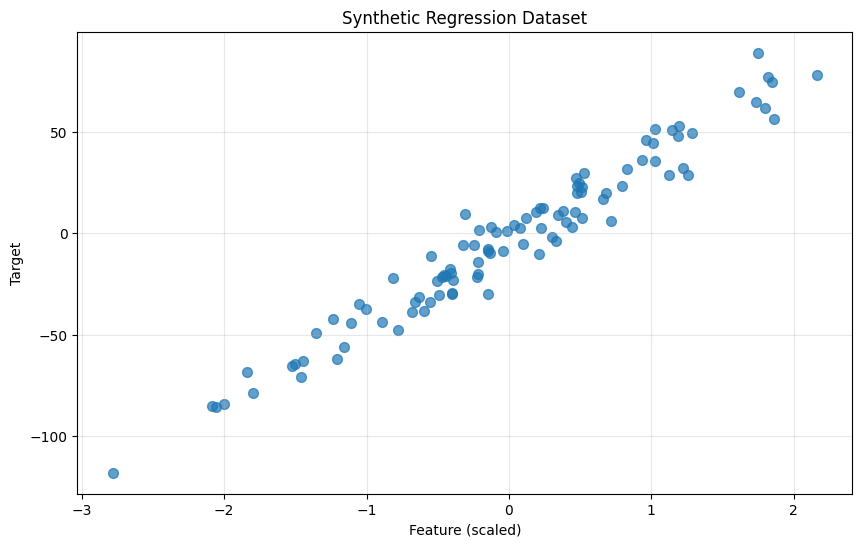


✓ Regression dataset created and visualized!


In [4]:
# Generate synthetic regression dataset
def create_regression_dataset(n_samples=200, n_features=1, noise=0.1, random_state=42):
    """
    Create a synthetic regression dataset
    """
    np.random.seed(random_state)
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        noise=noise*100,  # Scale noise appropriately
        random_state=random_state
    )
    return X, y

# Create dataset
X_reg, y_reg = create_regression_dataset(n_samples=100, n_features=1, noise=0.1)

# Standardize features for better convergence
scaler = StandardScaler()
X_reg_scaled = scaler.fit_transform(X_reg)

print(f"Regression dataset created:")
print(f"Shape: {X_reg_scaled.shape}")
print(f"Target range: [{np.min(y_reg):.2f}, {np.max(y_reg):.2f}]")

# Visualize the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X_reg_scaled[:, 0], y_reg, alpha=0.7, s=50)
plt.xlabel('Feature (scaled)')
plt.ylabel('Target')
plt.title('Synthetic Regression Dataset')
plt.grid(True, alpha=0.3)
plt.show()

print("\n✓ Regression dataset created and visualized!")


Training with learning rate: 0.001
------------------------------
Iteration 0: Cost = 851.227127
Iteration 100: Cost = 703.933706
Iteration 200: Cost = 583.352119
Iteration 300: Cost = 484.638144
Iteration 400: Cost = 403.826064
Iteration 500: Cost = 337.669350
Iteration 600: Cost = 283.510233
Iteration 700: Cost = 239.172935
Iteration 800: Cost = 202.876258
Iteration 900: Cost = 173.162026
Final R² score: -137.2287
Final cost: 149.056453
Learned weight: 25.3891
Learned bias: -2.1793

Training with learning rate: 0.01
------------------------------
Iteration 0: Cost = 850.565380
Iteration 100: Cost = 147.756757
Iteration 200: Cost = 53.594686
Iteration 300: Cost = 40.978882
Iteration 400: Cost = 39.288621
Iteration 500: Cost = 39.062160
Iteration 600: Cost = 39.031819
Iteration 700: Cost = 39.027754
Iteration 800: Cost = 39.027209
Converged at iteration 827
Final R² score: -194.3362
Final cost: 39.027174
Learned weight: 40.1444
Learned bias: -3.4487

Training with learning rate: 0.1
-

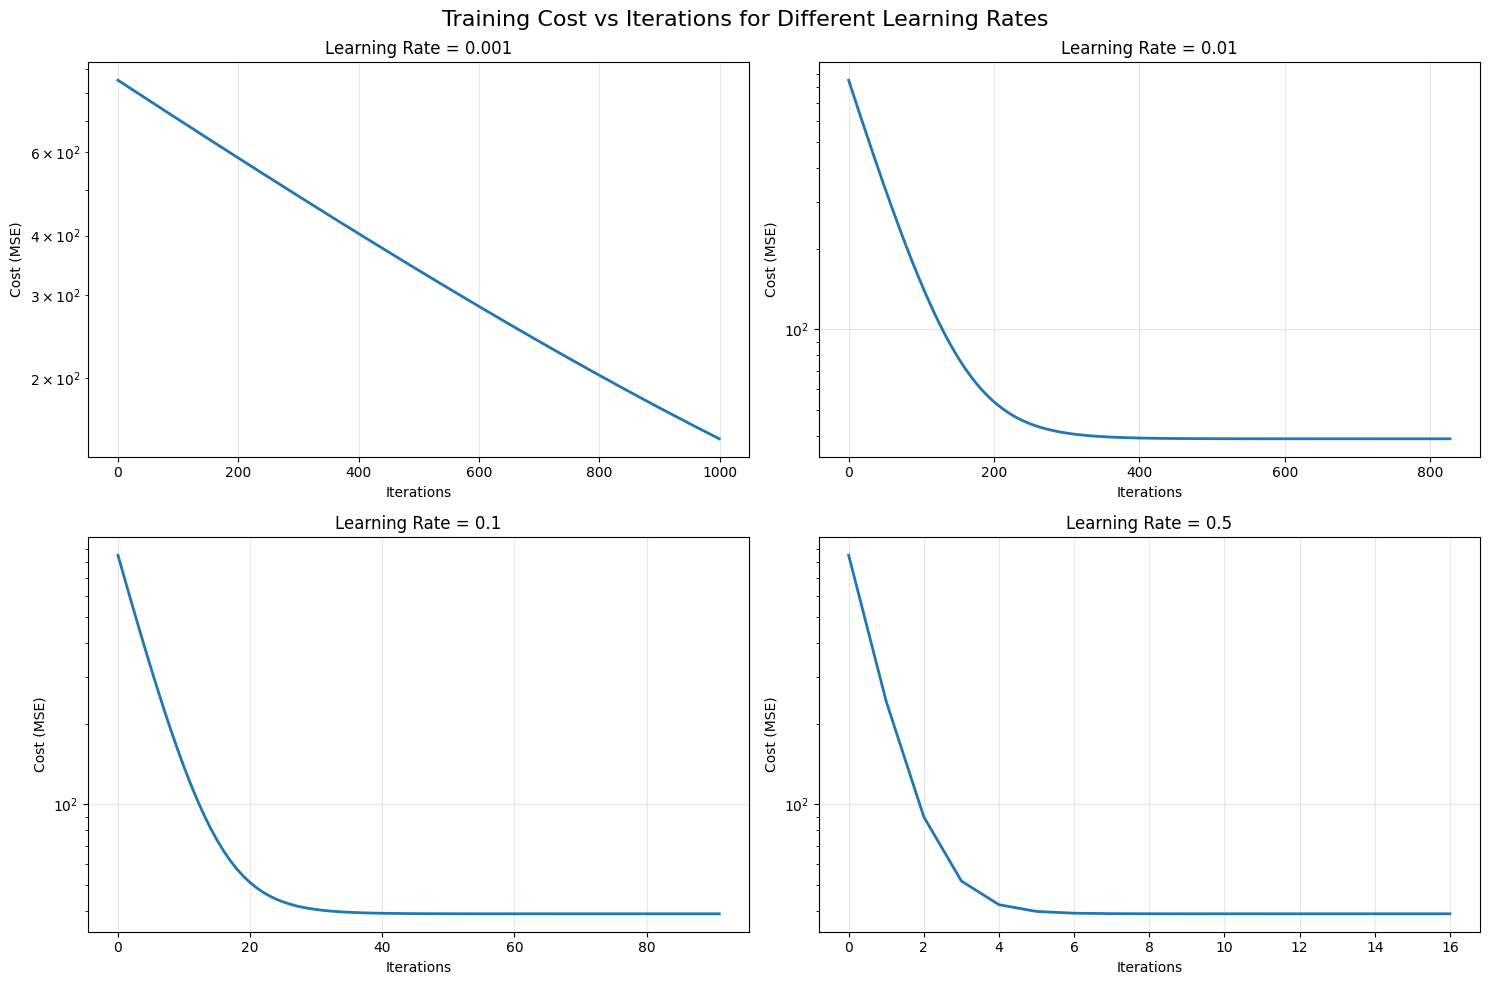


✓ Linear regression training with different learning rates completed!


In [5]:
# Train linear regression with different learning rates
learning_rates = [0.001, 0.01, 0.1, 0.5]
models = {}

plt.figure(figsize=(15, 10))

for i, lr in enumerate(learning_rates):
    print(f"\nTraining with learning rate: {lr}")
    print("-" * 30)
    
    # Create and train model
    model = LinearRegressionGD(learning_rate=lr, max_iterations=1000)
    model.fit(X_reg_scaled, y_reg)
    
    models[lr] = model
    
    # Calculate performance
    train_score = model.score(X_reg_scaled, y_reg)
    final_cost = model.cost_history[-1]
    
    print(f"Final R² score: {train_score:.4f}")
    print(f"Final cost: {final_cost:.6f}")
    print(f"Learned weight: {model.weights[0, 0]:.4f}")
    print(f"Learned bias: {model.bias:.4f}")
    
    # Plot cost history
    plt.subplot(2, 2, i + 1)
    plt.plot(model.cost_history, linewidth=2)
    plt.title(f'Learning Rate = {lr}')
    plt.xlabel('Iterations')
    plt.ylabel('Cost (MSE)')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization

plt.suptitle('Training Cost vs Iterations for Different Learning Rates', fontsize=16)
plt.tight_layout()
plt.show()

print("\n✓ Linear regression training with different learning rates completed!")

## Step 4: Visualize Gradient Descent in 2D Parameter Space

Let's visualize how gradient descent navigates the parameter space for a 2D linear regression problem.

True parameters: weights=[ 2.5 -1.5], bias=1.0
Iteration 0: Cost = 3.340893
Converged at iteration 67


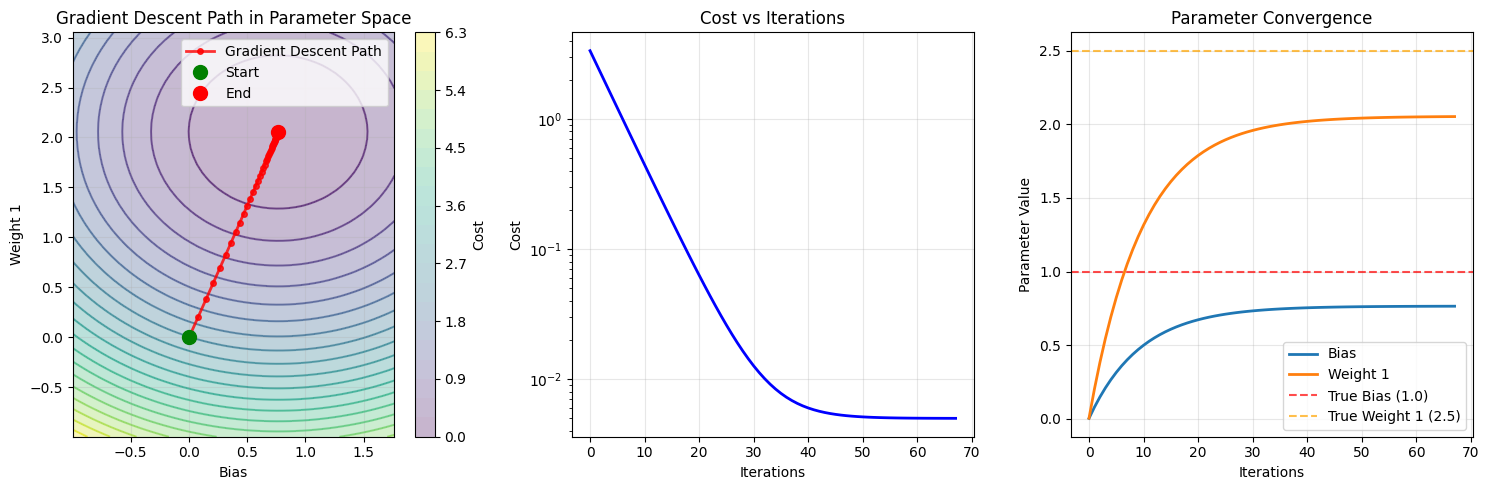


Final learned parameters:
Bias: 0.7643 (true: 1.0)
Weight 1: 2.0528 (true: 2.5)
Weight 2: -1.4643 (true: -1.5)
Final R² score: -98.8152

✓ 2D gradient descent visualization completed!


In [6]:
def visualize_2d_gradient_descent():
    """
    Visualize gradient descent in 2D parameter space
    """
    # Create simple 2D dataset
    np.random.seed(42)
    n_samples = 50
    X_simple = np.random.randn(n_samples, 2)
    true_weights = np.array([2.5, -1.5])
    true_bias = 1.0
    y_simple = X_simple.dot(true_weights) + true_bias + 0.1 * np.random.randn(n_samples)
    
    # Standardize features
    X_simple = (X_simple - np.mean(X_simple, axis=0)) / np.std(X_simple, axis=0)
    
    print(f"True parameters: weights={true_weights}, bias={true_bias:.1f}")
    
    # Train model and track weight history
    model = LinearRegressionGD(learning_rate=0.1, max_iterations=100)
    model.fit(X_simple, y_simple)
    
    # Extract weight history (bias and first weight only for 2D visualization)
    weight_history = np.array(model.weight_history)
    bias_history = weight_history[:, 0, 0]  # bias
    w1_history = weight_history[:, 1, 0]    # first weight
    
    # Create cost surface
    bias_range = np.linspace(bias_history.min() - 1, bias_history.max() + 1, 50)
    w1_range = np.linspace(w1_history.min() - 1, w1_history.max() + 1, 50)
    B, W1 = np.meshgrid(bias_range, w1_range)
    
    # Compute cost surface (fixing other weights to learned values)
    X_with_bias = np.c_[np.ones((X_simple.shape[0], 1)), X_simple]
    y_simple_reshaped = y_simple.reshape(-1, 1)
    
    Z = np.zeros_like(B)
    for i in range(B.shape[0]):
        for j in range(B.shape[1]):
            # Create weight vector with current bias and w1, keeping w2 fixed
            test_weights = np.array([[B[i, j]], [W1[i, j]], [model.weights[1, 0]]])
            predictions = X_with_bias.dot(test_weights)
            cost = (1 / (2 * len(y_simple))) * np.sum((predictions - y_simple_reshaped) ** 2)
            Z[i, j] = cost
    
    # Plot the optimization path
    plt.figure(figsize=(15, 5))
    
    # 2D contour plot
    plt.subplot(1, 3, 1)
    contour = plt.contour(B, W1, Z, levels=20, alpha=0.6)
    plt.contourf(B, W1, Z, levels=20, alpha=0.3, cmap='viridis')
    plt.colorbar(label='Cost')
    
    # Plot optimization path
    plt.plot(bias_history, w1_history, 'ro-', markersize=4, linewidth=2, 
            alpha=0.8, label='Gradient Descent Path')
    plt.plot(bias_history[0], w1_history[0], 'go', markersize=10, label='Start')
    plt.plot(bias_history[-1], w1_history[-1], 'ro', markersize=10, label='End')
    
    plt.xlabel('Bias')
    plt.ylabel('Weight 1')
    plt.title('Gradient Descent Path in Parameter Space')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Cost over iterations
    plt.subplot(1, 3, 2)
    plt.plot(model.cost_history, 'b-', linewidth=2)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost vs Iterations')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Parameter convergence
    plt.subplot(1, 3, 3)
    plt.plot(bias_history, label='Bias', linewidth=2)
    plt.plot(w1_history, label='Weight 1', linewidth=2)
    plt.axhline(y=true_bias, color='red', linestyle='--', alpha=0.7, label=f'True Bias ({true_bias})')
    plt.axhline(y=true_weights[0], color='orange', linestyle='--', alpha=0.7, label=f'True Weight 1 ({true_weights[0]})')
    plt.xlabel('Iterations')
    plt.ylabel('Parameter Value')
    plt.title('Parameter Convergence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final results
    print(f"\nFinal learned parameters:")
    print(f"Bias: {model.bias:.4f} (true: {true_bias:.1f})")
    print(f"Weight 1: {model.weights[0, 0]:.4f} (true: {true_weights[0]:.1f})")
    print(f"Weight 2: {model.weights[1, 0]:.4f} (true: {true_weights[1]:.1f})")
    print(f"Final R² score: {model.score(X_simple, y_simple):.4f}")

visualize_2d_gradient_descent()
print("\n✓ 2D gradient descent visualization completed!")

## Step 5: Stochastic and Mini-Batch Gradient Descent

Let's implement different variants of gradient descent and compare their behavior.

In [7]:
class GradientDescentVariants:
    """
    Implementation of different gradient descent variants
    """
    
    def __init__(self, learning_rate=0.01, max_iterations=1000):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.weights = None
        self.cost_history = []
        
    def _compute_cost(self, X, y, weights):
        """
        Compute MSE cost
        """
        m = len(y)
        predictions = X.dot(weights)
        cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
        return cost
    
    def batch_gradient_descent(self, X, y):
        """
        Standard (batch) gradient descent
        Uses the entire dataset for each update
        """
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        
        # Add bias column
        X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]
        
        # Initialize weights
        self.weights = np.random.normal(0, 0.01, (X_with_bias.shape[1], 1))
        self.cost_history = []
        
        m = len(y)
        
        for i in range(self.max_iterations):
            # Forward pass
            predictions = X_with_bias.dot(self.weights)
            cost = self._compute_cost(X_with_bias, y, self.weights)
            self.cost_history.append(cost)
            
            # Compute gradients using entire dataset
            errors = predictions - y
            gradients = (1 / m) * X_with_bias.T.dot(errors)
            
            # Update weights
            self.weights -= self.learning_rate * gradients
            
            if i % 100 == 0:
                print(f"Batch GD - Iteration {i}: Cost = {cost:.6f}")
        
        return self.weights, self.cost_history
    
    def stochastic_gradient_descent(self, X, y):
        """
        Stochastic gradient descent
        Uses one sample at a time for each update
        """
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        
        # Add bias column
        X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]
        
        # Initialize weights
        self.weights = np.random.normal(0, 0.01, (X_with_bias.shape[1], 1))
        self.cost_history = []
        
        m = len(y)
        
        for epoch in range(self.max_iterations):
            # Shuffle data for each epoch
            indices = np.random.permutation(m)
            X_shuffled = X_with_bias[indices]
            y_shuffled = y[indices]
            
            epoch_cost = 0
            
            # Process one sample at a time
            for i in range(m):
                xi = X_shuffled[i:i+1]  # Single sample
                yi = y_shuffled[i:i+1]
                
                # Forward pass
                prediction = xi.dot(self.weights)
                error = prediction - yi
                
                # Compute gradient for single sample
                gradient = xi.T.dot(error)
                
                # Update weights
                self.weights -= self.learning_rate * gradient
                
                # Accumulate cost for epoch
                epoch_cost += (1 / (2 * m)) * (error ** 2)
            
            self.cost_history.append(epoch_cost[0, 0])
            
            if epoch % 100 == 0:
                print(f"SGD - Epoch {epoch}: Cost = {epoch_cost[0, 0]:.6f}")
        
        return self.weights, self.cost_history
    
    def mini_batch_gradient_descent(self, X, y, batch_size=32):
        """
        Mini-batch gradient descent
        Uses small batches for each update
        """
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        
        # Add bias column
        X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]
        
        # Initialize weights
        self.weights = np.random.normal(0, 0.01, (X_with_bias.shape[1], 1))
        self.cost_history = []
        
        m = len(y)
        n_batches = (m + batch_size - 1) // batch_size
        
        for epoch in range(self.max_iterations):
            # Shuffle data
            indices = np.random.permutation(m)
            X_shuffled = X_with_bias[indices]
            y_shuffled = y[indices]
            
            epoch_cost = 0
            
            # Process mini-batches
            for batch_idx in range(n_batches):
                start_idx = batch_idx * batch_size
                end_idx = min((batch_idx + 1) * batch_size, m)
                
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                batch_size_actual = len(X_batch)
                
                # Forward pass
                predictions = X_batch.dot(self.weights)
                errors = predictions - y_batch
                
                # Compute gradients for batch
                gradients = (1 / batch_size_actual) * X_batch.T.dot(errors)
                
                # Update weights
                self.weights -= self.learning_rate * gradients
                
                # Accumulate cost
                batch_cost = (1 / (2 * batch_size_actual)) * np.sum(errors ** 2)
                epoch_cost += batch_cost * batch_size_actual / m
            
            self.cost_history.append(epoch_cost)
            
            if epoch % 100 == 0:
                print(f"Mini-batch GD (batch_size={batch_size}) - Epoch {epoch}: Cost = {epoch_cost:.6f}")
        
        return self.weights, self.cost_history

print("✓ GradientDescentVariants class implemented successfully!")

✓ GradientDescentVariants class implemented successfully!


Large dataset created: (500, 2)

Running Batch GD...
Batch GD - Iteration 0: Cost = 239.332426
Batch GD - Iteration 100: Cost = 77.284283
Final cost: 54.555937

Running Stochastic GD...
SGD - Epoch 0: Cost = 72.639244
SGD - Epoch 100: Cost = 51.845518
Final cost: 52.036444

Running Mini-batch GD (32)...
Mini-batch GD (batch_size=32) - Epoch 0: Cost = 215.100988
Mini-batch GD (batch_size=32) - Epoch 100: Cost = 50.779454
Final cost: 50.783230

Running Mini-batch GD (64)...
Mini-batch GD (batch_size=64) - Epoch 0: Cost = 227.385212
Mini-batch GD (batch_size=64) - Epoch 100: Cost = 50.763437
Final cost: 50.756087


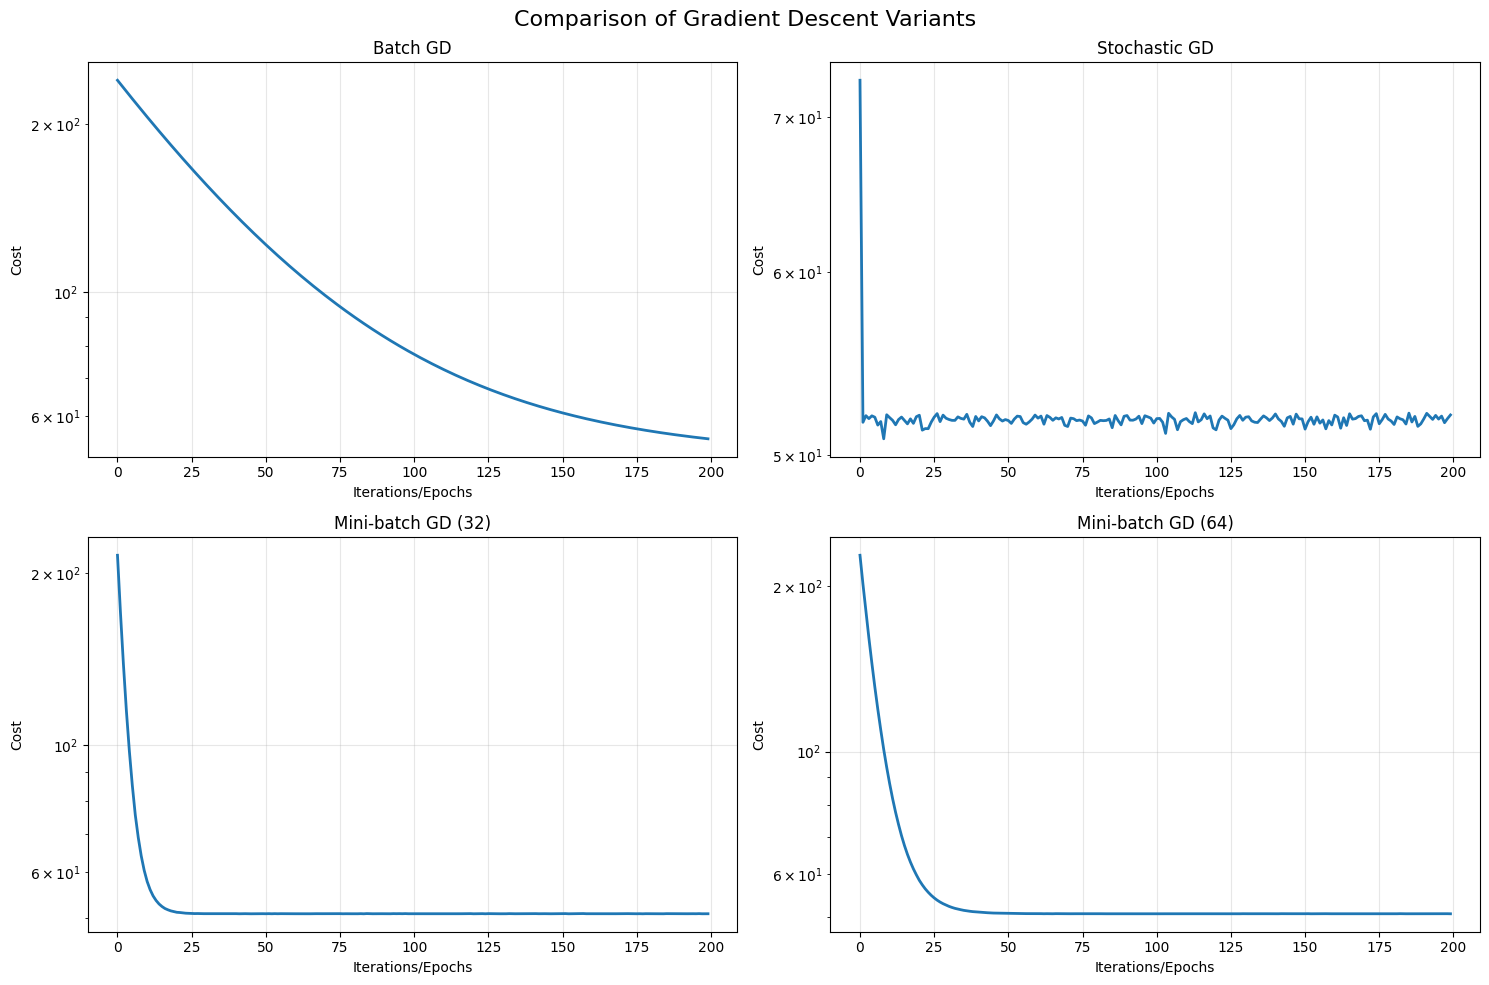

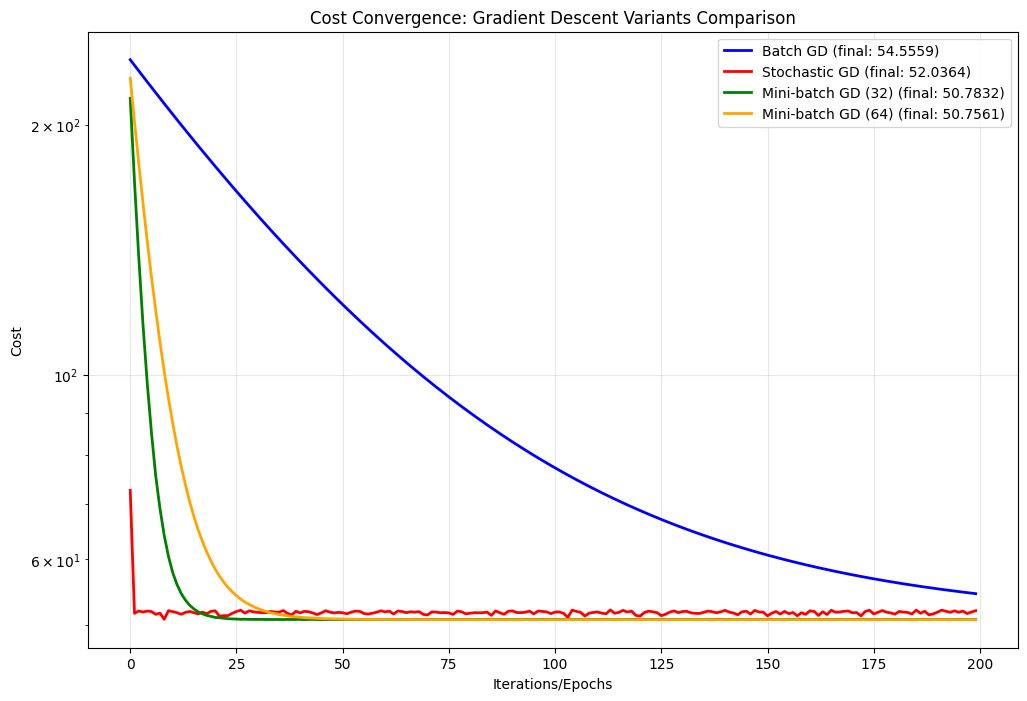


✓ Gradient descent variants comparison completed!


In [8]:
# Create a larger dataset to better see the differences
X_large, y_large = create_regression_dataset(n_samples=500, n_features=2, noise=0.1)
scaler_large = StandardScaler()
X_large_scaled = scaler_large.fit_transform(X_large)

print(f"Large dataset created: {X_large_scaled.shape}")

# Compare different gradient descent variants
variants = {
    'Batch GD': ('batch_gradient_descent', {}),
    'Stochastic GD': ('stochastic_gradient_descent', {}),
    'Mini-batch GD (32)': ('mini_batch_gradient_descent', {'batch_size': 32}),
    'Mini-batch GD (64)': ('mini_batch_gradient_descent', {'batch_size': 64})
}

results = {}
learning_rate = 0.01
max_iter = 200

plt.figure(figsize=(15, 10))

for i, (name, (method_name, kwargs)) in enumerate(variants.items()):
    print(f"\nRunning {name}...")
    print("=" * 30)
    
    # Create model
    model = GradientDescentVariants(learning_rate=learning_rate, max_iterations=max_iter)
    
    # Get method and run it
    method = getattr(model, method_name)
    weights, cost_history = method(X_large_scaled, y_large, **kwargs)
    
    results[name] = {
        'model': model,
        'weights': weights,
        'cost_history': cost_history,
        'final_cost': cost_history[-1]
    }
    
    print(f"Final cost: {cost_history[-1]:.6f}")
    
    # Plot cost history
    plt.subplot(2, 2, i + 1)
    plt.plot(cost_history, linewidth=2, label=name)
    plt.title(f'{name}')
    plt.xlabel('Iterations/Epochs')
    plt.ylabel('Cost')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
plt.suptitle('Comparison of Gradient Descent Variants', fontsize=16)
plt.tight_layout()
plt.show()

# Compare all variants in one plot
plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'green', 'orange']
for i, (name, result) in enumerate(results.items()):
    plt.plot(result['cost_history'], color=colors[i], linewidth=2, 
            label=f"{name} (final: {result['final_cost']:.4f})")

plt.xlabel('Iterations/Epochs')
plt.ylabel('Cost')
plt.title('Cost Convergence: Gradient Descent Variants Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

print("\n✓ Gradient descent variants comparison completed!")

## Step 6: Advanced Gradient Descent Analysis

Let's analyze how gradient descent behaves with different conditions and understand common challenges.

Batch GD - Iteration 0: Cost = 3322.328742
Batch GD - Iteration 100: Cost = 2722.124402
Batch GD - Iteration 200: Cost = 2230.767823
Batch GD - Iteration 0: Cost = 3320.982426
Batch GD - Iteration 100: Cost = 455.945979
Batch GD - Iteration 200: Cost = 72.089328
Batch GD - Iteration 0: Cost = 3322.385817
Batch GD - Iteration 100: Cost = 12.703900
Batch GD - Iteration 200: Cost = 12.703898
Batch GD - Iteration 0: Cost = 3321.623394
Batch GD - Iteration 100: Cost = 12.703898
Batch GD - Iteration 200: Cost = 12.703898
Batch GD - Iteration 0: Cost = 3321.747608
Batch GD - Iteration 100: Cost = 12.703898
Batch GD - Iteration 200: Cost = 12.703898
Batch GD - Iteration 0: Cost = 3322.567588
Batch GD - Iteration 100: Cost = 12.703898
Batch GD - Iteration 200: Cost = 12.703898
Batch GD - Iteration 0: Cost = 3323.764855
Batch GD - Iteration 100: Cost = 12.703898
Batch GD - Iteration 200: Cost = 12.703898
Batch GD - Iteration 0: Cost = 3322.610220
Batch GD - Iteration 100: Cost = 12.703898
Batch 

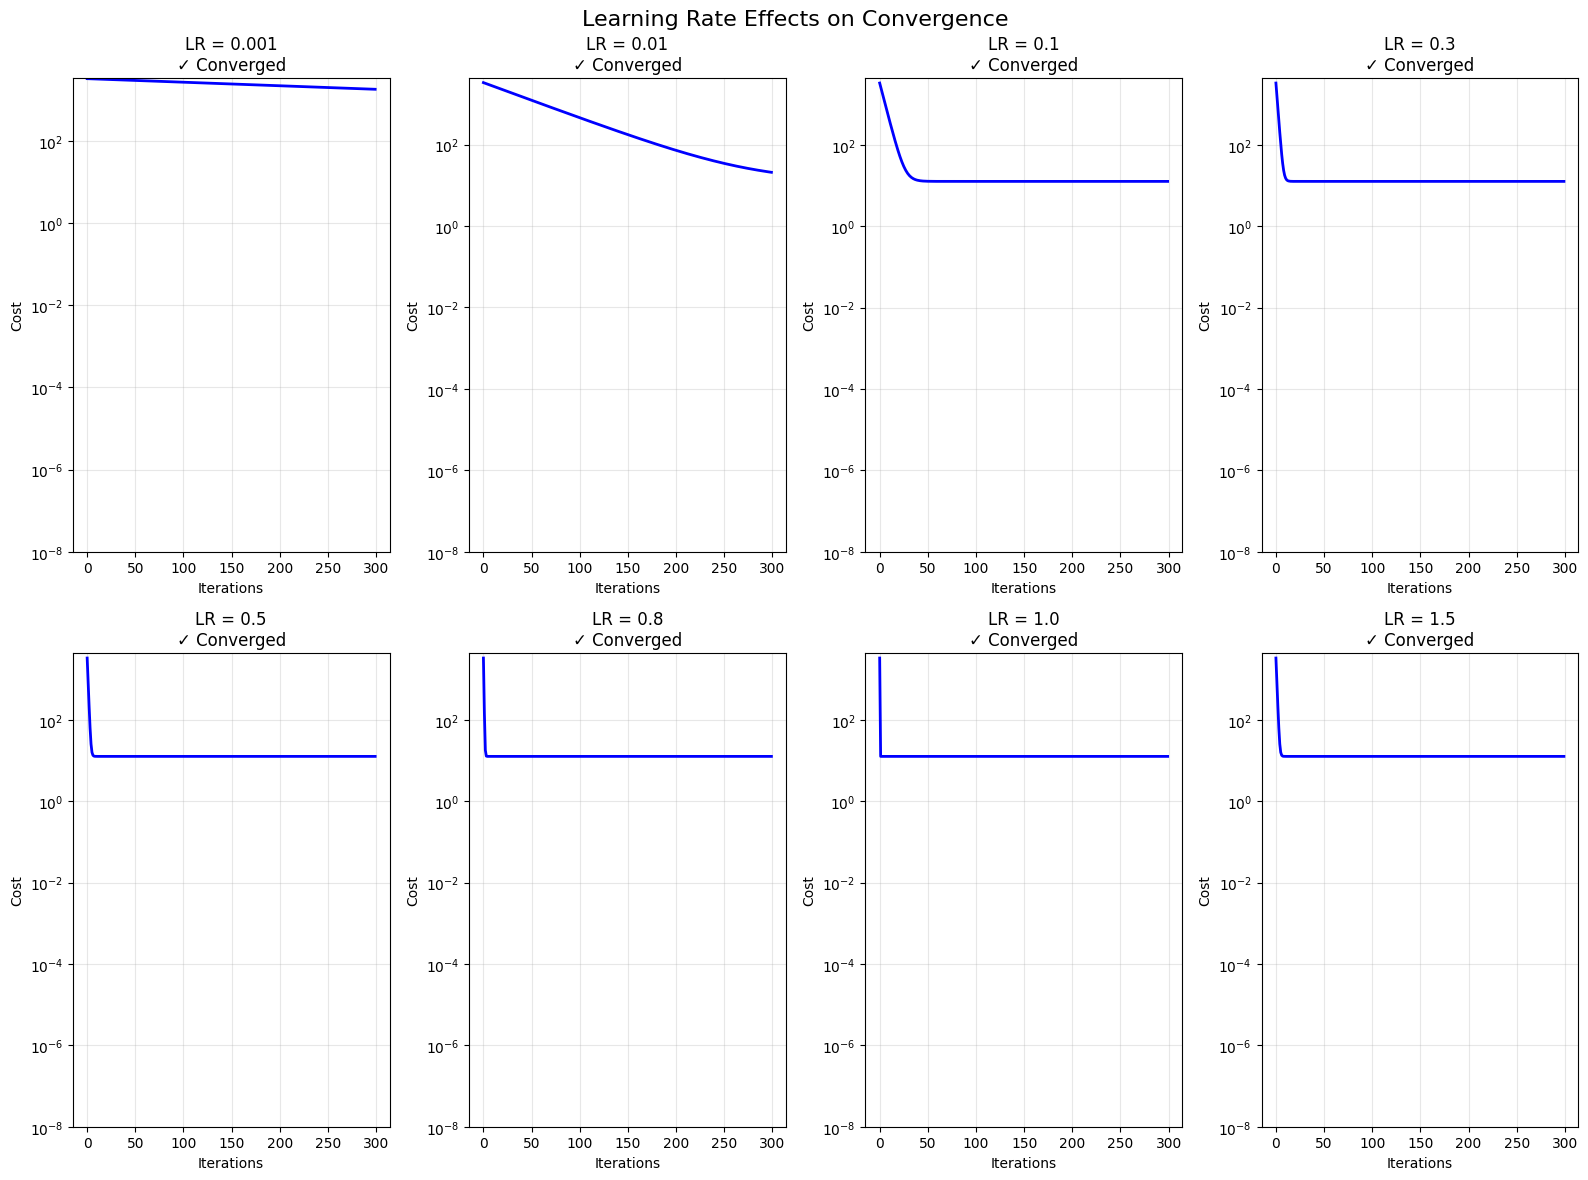

Learning Rate Analysis Summary:
LR     Converged  Final Cost   Status         
---------------------------------------------
0.001  Yes        1832.156419  Too Slow       
0.01   Yes        20.821886    Good           
0.1    Yes        12.703898    Good           
0.3    Yes        12.703898    Good           
0.5    Yes        12.703898    Good           
0.8    Yes        12.703898    Unstable       
1.0    Yes        12.703898    Unstable       
1.5    Yes        12.703898    Unstable       

✓ Learning rate analysis completed!


In [9]:
def analyze_learning_rate_effects():
    """
    Analyze the effects of different learning rates in detail
    """
    # Create dataset
    X_analysis, y_analysis = create_regression_dataset(n_samples=200, n_features=1, noise=0.05)
    X_analysis_scaled = StandardScaler().fit_transform(X_analysis)
    
    # Test a wide range of learning rates
    learning_rates = [0.001, 0.01, 0.1, 0.3, 0.5, 0.8, 1.0, 1.5]
    max_iterations = 300
    
    results = {}
    
    plt.figure(figsize=(16, 12))
    
    for i, lr in enumerate(learning_rates):
        model = GradientDescentVariants(learning_rate=lr, max_iterations=max_iterations)
        
        try:
            weights, cost_history = model.batch_gradient_descent(X_analysis_scaled, y_analysis)
            
            results[lr] = {
                'cost_history': cost_history,
                'converged': True,
                'final_cost': cost_history[-1],
                'weights': weights
            }
            
            # Check for divergence
            if np.any(np.isnan(cost_history)) or np.any(np.isinf(cost_history)):
                results[lr]['converged'] = False
                results[lr]['final_cost'] = np.inf
            
        except:
            results[lr] = {
                'cost_history': [np.inf] * max_iterations,
                'converged': False,
                'final_cost': np.inf,
                'weights': None
            }
        
        # Plot cost curves
        plt.subplot(2, 4, i + 1)
        
        if results[lr]['converged'] and results[lr]['final_cost'] != np.inf:
            plt.plot(cost_history, 'b-', linewidth=2)
            plt.title(f'LR = {lr}\n✓ Converged')
            plt.yscale('log')
        else:
            plt.plot(cost_history[:10], 'r-', linewidth=2)
            plt.title(f'LR = {lr}\n✗ Diverged')
        
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.grid(True, alpha=0.3)
        plt.ylim(bottom=1e-8)
    
    plt.suptitle('Learning Rate Effects on Convergence', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Summary analysis
    print("Learning Rate Analysis Summary:")
    print("=" * 35)
    print(f"{'LR':<6} {'Converged':<10} {'Final Cost':<12} {'Status':<15}")
    print("-" * 45)
    
    for lr in learning_rates:
        result = results[lr]
        converged = "Yes" if result['converged'] else "No"
        final_cost = f"{result['final_cost']:.6f}" if result['final_cost'] != np.inf else "Inf"
        
        if not result['converged']:
            status = "Diverged"
        elif lr < 0.01:
            status = "Too Slow"
        elif lr > 0.5:
            status = "Unstable"
        else:
            status = "Good"
        
        print(f"{lr:<6} {converged:<10} {final_cost:<12} {status:<15}")
    
    return results

lr_analysis_results = analyze_learning_rate_effects()
print("\n✓ Learning rate analysis completed!")

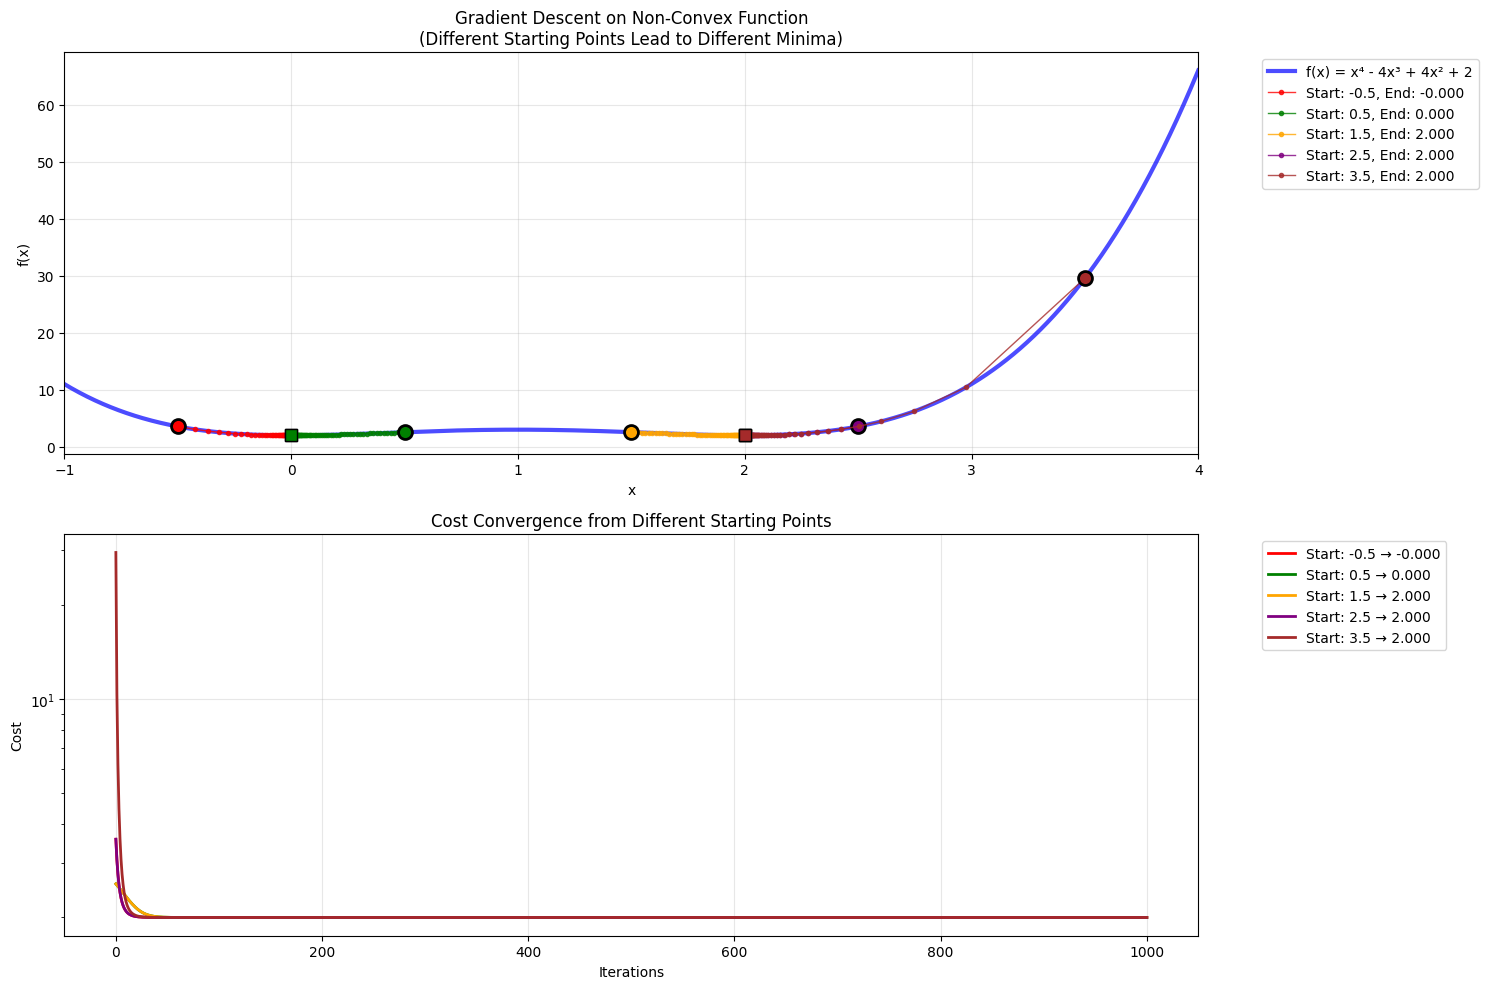

Local Minima Analysis:
Start    End      Final Cost   Local Minimum  
---------------------------------------------
-0.5     -0.000   2.0000       x ≈ 0          
0.5      0.000    2.0000       x ≈ 0          
1.5      2.000    2.0000       x ≈ 2          
2.5      2.000    2.0000       x ≈ 2          
3.5      2.000    2.0000       x ≈ 2          

✓ Local minima demonstration completed!


In [10]:
def demonstrate_local_minima():
    """
    Demonstrate gradient descent behavior with non-convex functions
    """
    def non_convex_function(x):
        """
        Non-convex function with multiple local minima
        f(x) = x^4 - 4x^3 + 4x^2 + 2
        """
        return x**4 - 4*x**3 + 4*x**2 + 2
    
    def non_convex_derivative(x):
        """
        Derivative of non-convex function
        f'(x) = 4x^3 - 12x^2 + 8x
        """
        return 4*x**3 - 12*x**2 + 8*x
    
    # Test different starting points
    starting_points = [-0.5, 0.5, 1.5, 2.5, 3.5]
    learning_rate = 0.01
    max_iterations = 1000
    
    plt.figure(figsize=(15, 10))
    
    # Plot the function
    x_range = np.linspace(-1, 4, 1000)
    y_range = non_convex_function(x_range)
    
    plt.subplot(2, 1, 1)
    plt.plot(x_range, y_range, 'b-', linewidth=3, alpha=0.7, label='f(x) = x⁴ - 4x³ + 4x² + 2')
    
    colors = ['red', 'green', 'orange', 'purple', 'brown']
    results = []
    
    for i, start_x in enumerate(starting_points):
        # Run gradient descent
        x_hist, cost_hist = gradient_descent_1d(
            start_x, learning_rate, max_iterations,
            non_convex_function, non_convex_derivative
        )
        
        results.append((start_x, x_hist, cost_hist))
        
        # Plot optimization path
        plt.plot(x_hist, cost_hist, 'o-', color=colors[i], 
                markersize=3, linewidth=1, alpha=0.8,
                label=f'Start: {start_x}, End: {x_hist[-1]:.3f}')
        
        # Mark start and end points
        plt.plot(start_x, non_convex_function(start_x), 'o', 
                color=colors[i], markersize=10, markeredgecolor='black', markeredgewidth=2)
        plt.plot(x_hist[-1], cost_hist[-1], 's', 
                color=colors[i], markersize=8, markeredgecolor='black', markeredgewidth=1)
    
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('Gradient Descent on Non-Convex Function\n(Different Starting Points Lead to Different Minima)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xlim(-1, 4)
    
    # Plot cost histories
    plt.subplot(2, 1, 2)
    for i, (start_x, x_hist, cost_hist) in enumerate(results):
        plt.plot(cost_hist, color=colors[i], linewidth=2, 
                label=f'Start: {start_x} → {x_hist[-1]:.3f}')
    
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost Convergence from Different Starting Points')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Analysis
    print("Local Minima Analysis:")
    print("=" * 25)
    print(f"{'Start':<8} {'End':<8} {'Final Cost':<12} {'Local Minimum':<15}")
    print("-" * 45)
    
    for start_x, x_hist, cost_hist in results:
        final_x = x_hist[-1]
        final_cost = cost_hist[-1]
        
        # Determine which local minimum was reached
        if abs(final_x - 0) < 0.1:
            local_min = "x ≈ 0"
        elif abs(final_x - 2) < 0.1:
            local_min = "x ≈ 2"
        else:
            local_min = f"x ≈ {final_x:.2f}"
        
        print(f"{start_x:<8.1f} {final_x:<8.3f} {final_cost:<12.4f} {local_min:<15}")

demonstrate_local_minima()
print("\n✓ Local minima demonstration completed!")

## Step 7: Gradient Descent for Logistic Regression

Let's apply gradient descent to logistic regression and compare with our previous implementation.

In [11]:
class LogisticRegressionGD:
    """
    Logistic Regression with explicit gradient descent implementation
    """
    
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        
        self.weights = None
        self.cost_history = []
        self.weight_history = []
        self.gradient_norms = []
    
    def _sigmoid(self, z):
        """Sigmoid activation function"""
        # Clip z to prevent overflow
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _compute_cost(self, X, y, weights):
        """
        Compute logistic regression cost (cross-entropy)
        """
        m = len(y)
        z = X.dot(weights)
        A = self._sigmoid(z)
        
        # Prevent log(0) by clipping
        A = np.clip(A, 1e-15, 1 - 1e-15)
        
        cost = -1/m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
        return cost
    
    def _compute_gradients(self, X, y, weights):
        """
        Compute gradients for logistic regression
        """
        m = len(y)
        z = X.dot(weights)
        A = self._sigmoid(z)
        
        gradients = 1/m * X.T.dot(A - y)
        return gradients
    
    def fit(self, X, y, variant='batch', batch_size=32):
        """
        Train logistic regression using gradient descent
        
        Arguments:
        X -- features
        y -- binary target (0 or 1)
        variant -- 'batch', 'stochastic', or 'mini-batch'
        batch_size -- size for mini-batch variant
        """
        # Ensure y is column vector
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        
        # Add bias column
        X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]
        
        # Initialize weights
        self.weights = np.random.normal(0, 0.01, (X_with_bias.shape[1], 1))
        
        # Initialize tracking
        self.cost_history = []
        self.weight_history = []
        self.gradient_norms = []
        
        if variant == 'batch':
            self._batch_gradient_descent(X_with_bias, y)
        elif variant == 'stochastic':
            self._stochastic_gradient_descent(X_with_bias, y)
        elif variant == 'mini-batch':
            self._mini_batch_gradient_descent(X_with_bias, y, batch_size)
    
    def _batch_gradient_descent(self, X, y):
        """Batch gradient descent for logistic regression"""
        for i in range(self.max_iterations):
            # Compute cost and gradients
            cost = self._compute_cost(X, y, self.weights)
            gradients = self._compute_gradients(X, y, self.weights)
            
            # Track progress
            self.cost_history.append(cost)
            self.weight_history.append(self.weights.copy())
            grad_norm = np.linalg.norm(gradients)
            self.gradient_norms.append(grad_norm)
            
            # Update weights
            self.weights -= self.learning_rate * gradients
            
            # Check convergence
            if grad_norm < self.tolerance:
                print(f"Converged at iteration {i} (gradient norm: {grad_norm:.2e})")
                break
            
            if i % 100 == 0:
                print(f"Iteration {i}: Cost = {cost:.6f}, Grad norm = {grad_norm:.2e}")
    
    def _mini_batch_gradient_descent(self, X, y, batch_size):
        """Mini-batch gradient descent for logistic regression"""
        m = len(y)
        n_batches = (m + batch_size - 1) // batch_size
        
        for epoch in range(self.max_iterations):
            # Shuffle data
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            epoch_cost = 0
            epoch_grad_norm = 0
            
            for batch in range(n_batches):
                start_idx = batch * batch_size
                end_idx = min((batch + 1) * batch_size, m)
                
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                
                # Compute gradients for batch
                gradients = self._compute_gradients(X_batch, y_batch, self.weights)
                
                # Update weights
                self.weights -= self.learning_rate * gradients
                
                # Accumulate metrics
                batch_cost = self._compute_cost(X_batch, y_batch, self.weights)
                epoch_cost += batch_cost * len(X_batch) / m
                epoch_grad_norm += np.linalg.norm(gradients) * len(X_batch) / m
            
            # Track progress
            self.cost_history.append(epoch_cost)
            self.weight_history.append(self.weights.copy())
            self.gradient_norms.append(epoch_grad_norm)
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Cost = {epoch_cost:.6f}, Grad norm = {epoch_grad_norm:.2e}")
    
    def predict_proba(self, X):
        """Predict class probabilities"""
        X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]
        z = X_with_bias.dot(self.weights)
        return self._sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        """Make binary predictions"""
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

print("✓ LogisticRegressionGD class implemented successfully!")

✓ LogisticRegressionGD class implemented successfully!


Classification dataset: (300, 2)
Class distribution: [150 150]

Training Logistic Regression with batch gradient descent...
--------------------------------------------------
Iteration 0: Cost = 0.696995, Grad norm = 4.18e-01
Iteration 100: Cost = 0.272431, Grad norm = 9.42e-02
Iteration 200: Cost = 0.223419, Grad norm = 5.17e-02
Final accuracy: 92.33%

Training Logistic Regression with mini-batch gradient descent...
--------------------------------------------------
Epoch 0: Cost = 0.616444, Grad norm = 3.84e-01
Epoch 100: Cost = 0.179587, Grad norm = 6.71e-02
Epoch 200: Cost = 0.176357, Grad norm = 6.55e-02
Final accuracy: 92.67%


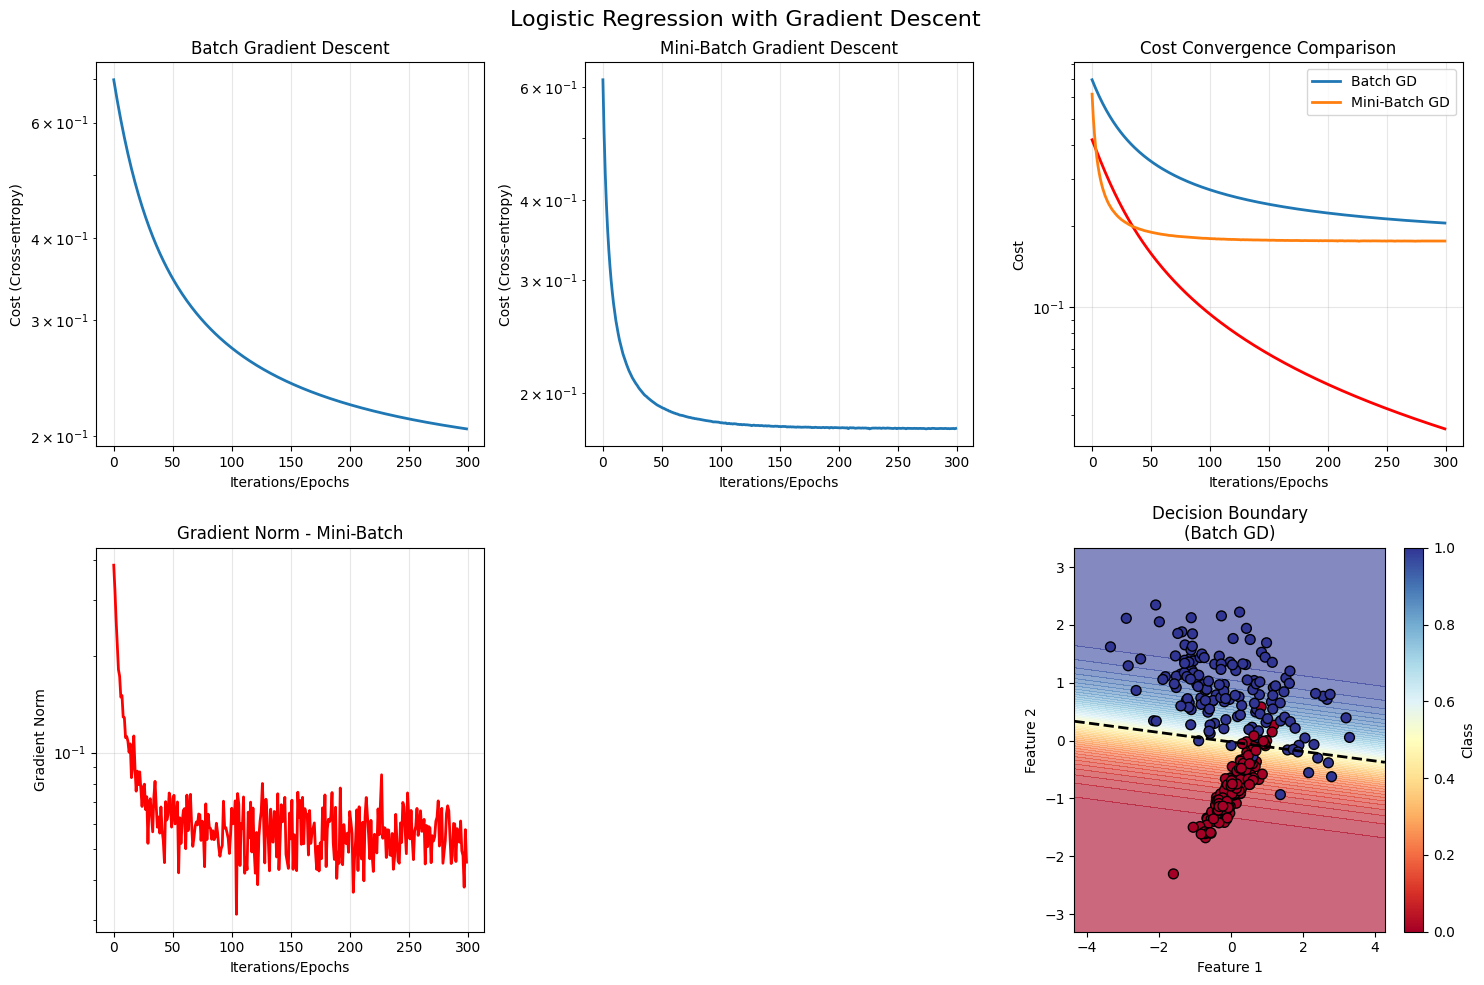


✓ Logistic regression with gradient descent completed!


In [12]:
# Create binary classification dataset
from sklearn.datasets import make_classification

X_cls, y_cls = make_classification(
    n_samples=300,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    random_state=42
)

# Standardize features
scaler_cls = StandardScaler()
X_cls_scaled = scaler_cls.fit_transform(X_cls)

print(f"Classification dataset: {X_cls_scaled.shape}")
print(f"Class distribution: {np.bincount(y_cls)}")

# Compare different gradient descent variants for logistic regression
variants_lr = ['batch', 'mini-batch']
lr_models = {}

plt.figure(figsize=(15, 10))

for i, variant in enumerate(variants_lr):
    print(f"\nTraining Logistic Regression with {variant} gradient descent...")
    print("-" * 50)
    
    model = LogisticRegressionGD(learning_rate=0.1, max_iterations=300)
    model.fit(X_cls_scaled, y_cls, variant=variant, batch_size=32)
    
    lr_models[variant] = model
    
    # Calculate accuracy
    predictions = model.predict(X_cls_scaled)
    accuracy = np.mean(predictions.ravel() == y_cls) * 100
    print(f"Final accuracy: {accuracy:.2f}%")
    
    # Plot cost history
    plt.subplot(2, 3, i + 1)
    plt.plot(model.cost_history, linewidth=2, label=f'{variant.title()} GD')
    plt.xlabel('Iterations/Epochs')
    plt.ylabel('Cost (Cross-entropy)')
    plt.title(f'{variant.title()} Gradient Descent')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Plot gradient norms
    plt.subplot(2, 3, i + 3)
    plt.plot(model.gradient_norms, linewidth=2, color='red')
    plt.xlabel('Iterations/Epochs')
    plt.ylabel('Gradient Norm')
    plt.title(f'Gradient Norm - {variant.title()}')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

# Compare cost convergence
plt.subplot(2, 3, 3)
for variant, model in lr_models.items():
    plt.plot(model.cost_history, linewidth=2, label=f'{variant.title()} GD')

plt.xlabel('Iterations/Epochs')
plt.ylabel('Cost')
plt.title('Cost Convergence Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Decision boundary visualization
plt.subplot(2, 3, 6)
model_viz = lr_models['batch']

# Create mesh for decision boundary
h = 0.02
x_min, x_max = X_cls_scaled[:, 0].min() - 1, X_cls_scaled[:, 0].max() + 1
y_min, y_max = X_cls_scaled[:, 1].min() - 1, X_cls_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))

# Get predictions on mesh
mesh_points = np.c_[xx.ravel(), yy.ravel()]
Z = model_viz.predict_proba(mesh_points)
Z = Z.reshape(xx.shape)

# Plot decision boundary and data
plt.contourf(xx, yy, Z, levels=50, alpha=0.6, cmap='RdYlBu')
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2, linestyles='--')
scatter = plt.scatter(X_cls_scaled[:, 0], X_cls_scaled[:, 1], c=y_cls, 
                     cmap='RdYlBu', edgecolors='black', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary\n(Batch GD)')
plt.colorbar(scatter, label='Class')

plt.suptitle('Logistic Regression with Gradient Descent', fontsize=16)
plt.tight_layout()
plt.show()

print("\n✓ Logistic regression with gradient descent completed!")

## Progress Tracking Checklist

Mark each completed section:

- [ ] ✅ **Environment Setup**: Set up environment and reviewed mathematical foundations
- [ ] ✅ **1D Visualization**: Implemented and visualized 1D gradient descent
- [ ] ✅ **Linear Regression GD**: Built complete gradient descent for linear regression
- [ ] ✅ **2D Parameter Space**: Visualized gradient descent navigation in parameter space
- [ ] ✅ **GD Variants**: Implemented batch, stochastic, and mini-batch gradient descent
- [ ] ✅ **Learning Rate Analysis**: Analyzed effects of different learning rates
- [ ] ✅ **Local Minima Demo**: Demonstrated behavior with non-convex functions
- [ ] ✅ **Logistic Regression GD**: Applied gradient descent to logistic regression
- [ ] ✅ **Performance Comparison**: Compared different variants and visualized results

## Key Concepts Summary

**Gradient Descent Fundamentals:**
1. **Core Algorithm**: θ = θ - α∇J(θ) iteratively minimizes cost function
2. **Learning Rate**: Controls step size; too small = slow, too large = divergence
3. **Convergence**: Algorithm stops when gradients become sufficiently small
4. **Global vs Local**: Convex functions guarantee global minimum; non-convex may get stuck

**Gradient Descent Variants:**
- **Batch GD**: Uses entire dataset; stable but slow for large data
- **Stochastic GD**: Uses one sample; fast but noisy updates
- **Mini-batch GD**: Best of both; uses small batches for balanced performance

**Learning Rate Effects:**
- **Too small (< 0.01)**: Very slow convergence, may not reach minimum in time
- **Good range (0.01-0.5)**: Stable convergence with reasonable speed
- **Too large (> 0.5)**: Oscillations, instability, potential divergence

**Practical Insights:**
- Feature scaling improves convergence speed and stability
- Different starting points may lead to different local minima
- Monitoring gradient norm helps detect convergence
- Mini-batch GD often provides best practical performance

## Troubleshooting

**Common Issues and Solutions:**

1. **Slow Convergence**
   - *Problem*: Cost decreases very slowly
   - *Solutions*: Increase learning rate, scale features, check for proper initialization

2. **Divergent Training**
   - *Problem*: Cost increases or oscillates wildly
   - *Solutions*: Reduce learning rate, check gradient computation, ensure proper data scaling

3. **Numerical Instability**
   - *Problem*: NaN or infinite values appear
   - *Solutions*: Clip gradients/values, reduce learning rate, check for division by zero

4. **Stuck in Local Minimum**
   - *Problem*: Algorithm converges to suboptimal solution
   - *Solutions*: Try different initializations, use momentum, add regularization

5. **Memory Issues**
   - *Problem*: Large datasets don't fit in memory
   - *Solutions*: Use mini-batch or stochastic GD, implement data generators

6. **Overfitting**
   - *Problem*: Model memorizes training data
   - *Solutions*: Add regularization, use validation set, implement early stopping

## Validation Steps

**Verify Your Implementation:**
1. ✅ Cost function decreases monotonically (for batch GD)
2. ✅ Gradient norms decrease over time
3. ✅ Different learning rates show expected behavior patterns
4. ✅ Mini-batch performance balances speed and stability
5. ✅ Final predictions achieve reasonable accuracy
6. ✅ Parameter values converge to sensible ranges

## Cleanup Instructions

**After Lab Completion:**
1. Save notebook with all visualizations and results
2. Clear large variables if memory is limited:
   ```python
   # Uncomment if needed
   # del X_large_scaled, lr_analysis_results
   # del lr_models, results
   ```
3. Close all plots: `plt.close('all')`

## Next Steps

You now have a deep understanding of gradient descent! This knowledge is fundamental for:
- Neural network training (next lab)
- Advanced optimizers (Adam, RMSprop)
- Deep learning frameworks
- Custom model development

The gradient descent principles you've learned apply to all machine learning optimization problems, making this one of the most important labs in the course.

**Congratulations! You've completed Lab 2.3 - Gradient Descent from Scratch!** 🎉